<a href="https://colab.research.google.com/github/IEwaspbusters/KopuruVespaCompetitionIE/blob/main/Competition_subs/2021-04-28_submit/batch_LARVAE/HEX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# XGBoost Years: Prediction with Cluster Variables and selected Weather Variables (according to Feature importance)

## Import the Data & Modules

In [1]:
# Base packages -----------------------------------
import pandas as pd
import numpy as np

# Data Viz -----------------------------------
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15, 10) # to set figure size when ploting feature_importance


# XGBoost -------------------------------
import xgboost as xgb
from xgboost import XGBRegressor
from xgboost import plot_importance # built-in function to plot features ordered by their importance

# SKLearn -----------------------------------------
from sklearn import preprocessing # scaling data

#Cluster
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from plotnine import *

In [80]:
# Function that checks if final Output is ready for submission or needs revision   

def check_data(HEX):
    
    def template_checker(HEX):
        submission_df = (HEX["CODIGO MUNICIPIO"].astype("string")+HEX["NOMBRE MUNICIPIO"]).sort_values().reset_index(drop=True)
        template_df = (template["CODIGO MUNICIPIO"].astype("string")+template["NOMBRE MUNICIPIO"]).sort_values().reset_index(drop=True)
        check_df = pd.DataFrame({"submission_df":submission_df,"template_df":template_df})
        check_df["check"] = check_df.submission_df == check_df.template_df
        if (check_df.check == False).any():
            pd.options.display.max_rows = 112
            return check_df.loc[check_df.check == False,:]
        else:  
            return "All Municipality Names and Codes to be submitted match the Template"
    
    print("Submission form Shape is", HEX.shape)
    print("Number of Municipalities is", HEX["CODIGO MUNICIPIO"].nunique())
    print("The Total 2020 Nests' Prediction is", int(HEX["NIDOS 2020"].sum()))

    assert HEX.shape == (112, 3), "Error: Shape is incorrect."
    assert HEX["CODIGO MUNICIPIO"].nunique() == 112, "Error: Number of unique municipalities is correct."    
    return template_checker(HEX)

In [52]:
# Importing datasets from GitHub as Pandas Dataframes
queen_train = pd.read_csv("../Feeder_years/WBds03_QUEENtrainYEARS.csv", encoding="utf-8") #2018+2019 test df
queen_predict = pd.read_csv("../Feeder_years/WBds03_QUEENpredictYEARS.csv", encoding="utf-8") #2020 prediction df
template = pd.read_csv("../../../Input_open_data/ds01_PLANTILLA-RETO-AVISPAS-KOPURU.csv",sep=";", encoding="utf-8")
den_com = pd.read_excel("../../../Other_open_data/densidad comercial.xlsx")

# New queen Train dataset

In [53]:
den_com_18= den_com.loc[:,['Código municipio','2018']]
den_com_18.rename({'2018': 'dens_com','Código municipio':'municip_code'}, axis=1, inplace=True)
den_com_18['year_offset']='2018'

den_com_17= den_com.loc[:,['Código municipio','2017']]
den_com_17.rename({'2017': 'dens_com','Código municipio':'municip_code'}, axis=1, inplace=True)
den_com_17['year_offset']='2017'

den_com_19= den_com.loc[:,['Código municipio','2019']]
den_com_19.rename({'2019': 'dens_com','Código municipio':'municip_code'}, axis=1, inplace=True)
den_com_19['year_offset']='2019'

densidad_comercial= den_com_18.append(den_com_17).append(den_com_19)
densidad_comercial['cod_aux']=densidad_comercial.apply(lambda x:'%s_%s' % (x['municip_code'],x['year_offset']),axis=1)


In [65]:
aux_train= queen_train.copy()
aux_train['cod_aux']=aux_train.apply(lambda x:'%s_%s' % (x['municip_code'],x['year_offset']),axis=1)

queen_train_mischief= aux_train.loc[:,
                                    ['municip_code','municip_name','weath_meanTemp',
                                     'population','cod_aux','NESTS']].merge(cluster_data,
                                                                            how='left', on='municip_code').merge(densidad_comercial,
                                                                                                                 how='left', on='cod_aux') 

                                                                                                                                                                                                                                                                                                                                                                                           
queen_train_mischief.drop(['cod_aux','municip_code_y'], axis=1, inplace=True)
queen_train_mischief.rename({'municip_code_x': 'municip_code'}, axis=1, inplace=True)
queen_train_mischief["dens_com"] = queen_train_mischief["dens_com"].apply(lambda x: x.replace(",", "."))


In [57]:
queen_predict_mischief= queen_predict.loc[:,['municip_code','municip_name','weath_meanTemp','year_offset','population']]
queen_predict_mischief['cod_aux']= queen_predict_mischief.apply(lambda x:'%s_%s' % (x['municip_code'],x['year_offset']),axis=1)
queen_predict_mischief= queen_predict_mischief.merge(densidad_comercial, how='left', on='cod_aux')
queen_predict_mischief.drop(['cod_aux','municip_code_y','year_offset_x','year_offset_y'], axis=1, inplace=True)
queen_predict_mischief.rename({'municip_code_x': 'municip_code'}, axis=1, inplace=True)
queen_predict_mischief["dens_com"] = queen_predict_mischief["dens_com"].apply(lambda x: x.replace(",", "."))


In [72]:
predict_20=queen_predict_mischief.loc[:,['weath_meanTemp', 'population', 'Cluster', 'dens_com']]

# Cluster

In [58]:
aux_cluster= queen_predict.drop(['population','station_code'], axis=1).iloc[:,3:31]

In [59]:
x_cluster = preprocessing.minmax_scale(aux_cluster) # this creates a numpy array

In [60]:
pca = PCA(n_components=0.99)
pca.fit(aux_cluster)
aux_dim= pca.transform(aux_cluster)


## Silouhette

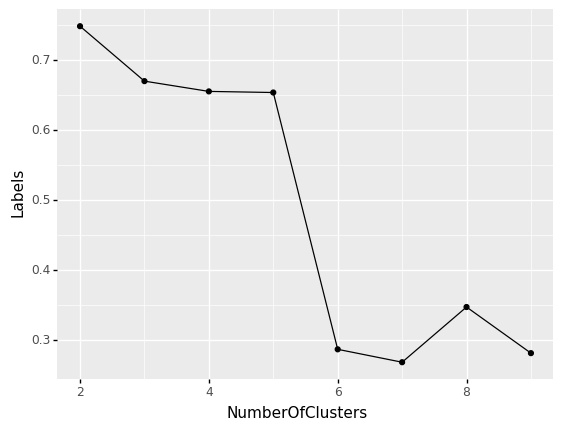

<ggplot: (-9223371962096218560)>

In [61]:
silhouettes = []

for i in range(2,10,1):
  model = KMeans(n_clusters=i)
  model.fit(aux_dim)
  labels = model.labels_
  sol = silhouette_score(aux_dim, labels)
  silhouettes.append(sol)

silhouette = pd.DataFrame()
silhouette['Labels'] = silhouettes
silhouette['NumberOfClusters'] = range(2,10,1)

ggplot(aes(x='NumberOfClusters', y='Labels'), silhouette) + geom_line() + geom_point()

In [62]:
silhouette_output = 2

## KMeans

In [63]:
# we decided to seek out 2 clusters, as per de Silhouette method
model = KMeans(n_clusters = silhouette_output)

model.fit(aux_dim)
modelLabels = model.labels_
modelCenters = model.cluster_centers_

queen_predict_mischief['Cluster'] = pd.Series(modelLabels, index=queen_predict_mischief.index)

In [64]:
cluster_data=queen_predict_mischief.loc[:,['municip_code', 'Cluster']]

## Get the Prediction

### Arrange data into a features matrix and target vector

In [66]:
# selecting the train X & y variables

# Y will be the response variable (filter for the number of wasp nests - waspbust_id)  
y = queen_train_mischief.NESTS

# X will be the explanatory variables. Remove response variable and non desired categorical columns such as (municip code, year, etc...)
X = queen_train_mischief.loc[:,['weath_meanTemp', 'population', 'Cluster', 'dens_com']]


### Scale the Data in order to filter the relevant variables using Feature Importance

#### Arrange data into a features matrix and target vector

In [67]:
# Scale the datasets using MinMaxScaler

X_scaled = preprocessing.minmax_scale(X) # this creates a numpy array

#### Choose a class of model by importing the appropriate estimator class

In [68]:
# selecting the XGBoost model and fitting with the train data
model = XGBRegressor()

#### Fit the model to your data by calling the `.fit()` method of the model instance

In [69]:
# selecting the XGBoost model and fitting with the train data for each cluster

model.fit(X_scaled, y)

XGBRegressor()

#### Selecting the Relevant Variables and filtering according to the results

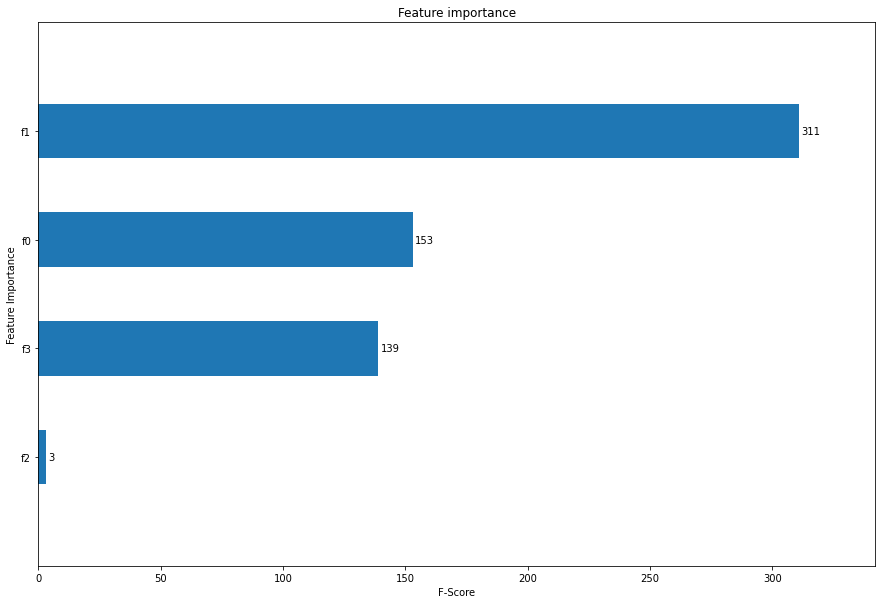

In [70]:
# Plot the Relevant Variables in order to filter the relevant ones per Cluster

plot_importance(model,height=0.5,xlabel="F-Score",ylabel="Feature Importance",grid=False)
plt.show()

### Fit the model to your data by calling the `.fit()` method of the model instance

### Apply the model to new data:

- For supervised learning, predict labels for unknown data using the `.predict()` method

In [73]:
# make a prediction
X_scaled_pred = preprocessing.minmax_scale(predict_20)
queen_predict_mischief['nests_2020'] = model.predict(X_scaled_pred)

In [74]:
queen_predict_mischief.nests_2020.sum()

2848.4233

In [76]:
queen_predict_mischief

,municip_code,municip_name,weath_meanTemp,population,dens_com,Cluster,nests_2020
0,48001,Abadiño,13.341667,7599,7.60,0,21.901279
1,48002,Abanto y Ciérvana-Abanto Zierbena,14.412870,9444,6.66,0,39.074093
2,48911,Ajangiz,13.816667,477,2.12,0,16.912497
3,48912,Alonsotegi,12.969818,2907,6.22,0,26.200155
4,48003,Amorebieta-Etxano,13.466667,19339,9.16,1,88.171234
...,...,...,...,...,...,...,...
107,48097,Zaratamo,14.476180,1614,7.39,0,20.273071
108,48024,Zeanuri,9.975000,1250,4.01,0,20.924303
109,48025,Zeberio,11.408333,1073,5.54,0,18.222347
110,48913,Zierbena,14.925000,1490,2.66,0,18.107595


## Add Each Cluster Predictions to the original DataFrame and Save it as a `.csv file`

In [78]:
HEX = queen_predict_mischief.loc[:,["municip_code","municip_name","nests_2020"]].round() # create a new Dataframe for Kopuru submission
HEX.columns = ["CODIGO MUNICIPIO","NOMBRE MUNICIPIO","NIDOS 2020"] # change column names to Spanish (Decidata template)


In [81]:
# Final check

check_data(HEX)

Submission form Shape is (112, 3)
Number of Municipalities is 112
The Total 2020 Nests' Prediction is 2851


'All Municipality Names and Codes to be submitted match the Template'

In [82]:
# reset max_rows to default values (used in function to see which rows did not match template)

pd.reset_option("max_rows")

In [83]:
# Save the new dataFrame as a .csv in the current working directory on Windows

HEX.to_csv("WaspBusters_20210602_XGyears_SuperCluster_PC1.csv", index=False)